In [43]:
pip install keras-unet-collection

Note: you may need to restart the kernel to use updated packages.


In [62]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from keras_unet_collection.models import unet_plus_2d


In [63]:
DATA_DIR = '/kaggle/input/brain-tumor-segmentation'  # change if needed
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR  = os.path.join(DATA_DIR, 'masks')

print("Total images:", len(os.listdir(IMAGE_DIR)))
print("Total masks :", len(os.listdir(MASK_DIR)))



Total images: 3064
Total masks : 3064


In [64]:
def simple_generator(img_dir, mask_dir, batch_size=8, target_size=(256, 256)):
    img_list = sorted(os.listdir(img_dir))
    mask_list = sorted(os.listdir(mask_dir))
    while True:
        for i in range(0, len(img_list), batch_size):
            batch_imgs = img_list[i:i+batch_size]
            batch_masks = mask_list[i:i+batch_size]
            imgs, masks = [], []
            for img_file, mask_file in zip(batch_imgs, batch_masks):
                img = load_img(os.path.join(img_dir, img_file), color_mode='grayscale', target_size=target_size)
                mask = load_img(os.path.join(mask_dir, mask_file), color_mode='grayscale', target_size=target_size)
                imgs.append(img_to_array(img) / 255.0)
                masks.append(img_to_array(mask) / 255.0)
            yield np.array(imgs), np.array(masks)


In [65]:
model = unet_plus_2d(
    input_size=(256, 256, 1),
    filter_num=[32, 64, 128],
    n_labels=1,
    deep_supervision=False,  # important fix
    stack_num_down=2,
    stack_num_up=2,
    activation='ReLU',
    output_activation='Sigmoid'
)


In [68]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [69]:
train_gen = simple_generator(IMAGE_DIR, MASK_DIR, batch_size=8)
steps = len(os.listdir(IMAGE_DIR)) // 8

model.fit(
    train_gen,
    steps_per_epoch=steps,
    epochs=20
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_322']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)
I0000 00:00:1750747705.947084     108 service.cc:148] XLA service 0x7d9fe000d8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750747705.947923     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750747705.947946     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750747706.568926     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750747719.548383     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/383 ━━━━━━━━━━━━━━━━━━━━ 87s 180ms/step - accuracy: 0.9865 - loss: 0.1924
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9866 - loss: 0.0598
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - accuracy: 0.9866 - loss: 0.0576
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - accuracy: 0.9866 - loss: 0.0563
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - accuracy: 0.9866 - loss: 0.0541
Epoch 6/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - accuracy: 0.9866 - loss: 0.0514
Epoch 7/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9866 - loss: 0.0494
Epoch 8/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - accuracy: 0.9866 - loss: 0.0476
Epoch 9/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9868 - loss: 0.0467
Epoch 10/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9870 - loss: 0.0451
Epoch 11/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9872 - loss: 0.0442
Epoch 12/20
383/383 ━━━━━━━━━━

In [70]:
os.makedirs('/kaggle/working/pred_masks', exist_ok=True)

for fname in sorted(os.listdir(IMAGE_DIR)):
    img = load_img(os.path.join(IMAGE_DIR, fname), color_mode='grayscale', target_size=(256, 256))
    x = np.expand_dims(img_to_array(img) / 255.0, axis=0)
    pred = model.predict(x)[0, ..., 0] > 0.5
    pred_img = (pred.astype(np.uint8)) * 255
    save_img(f'/kaggle/working/pred_masks/{fname}', pred_img[..., np.newaxis])


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_322']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


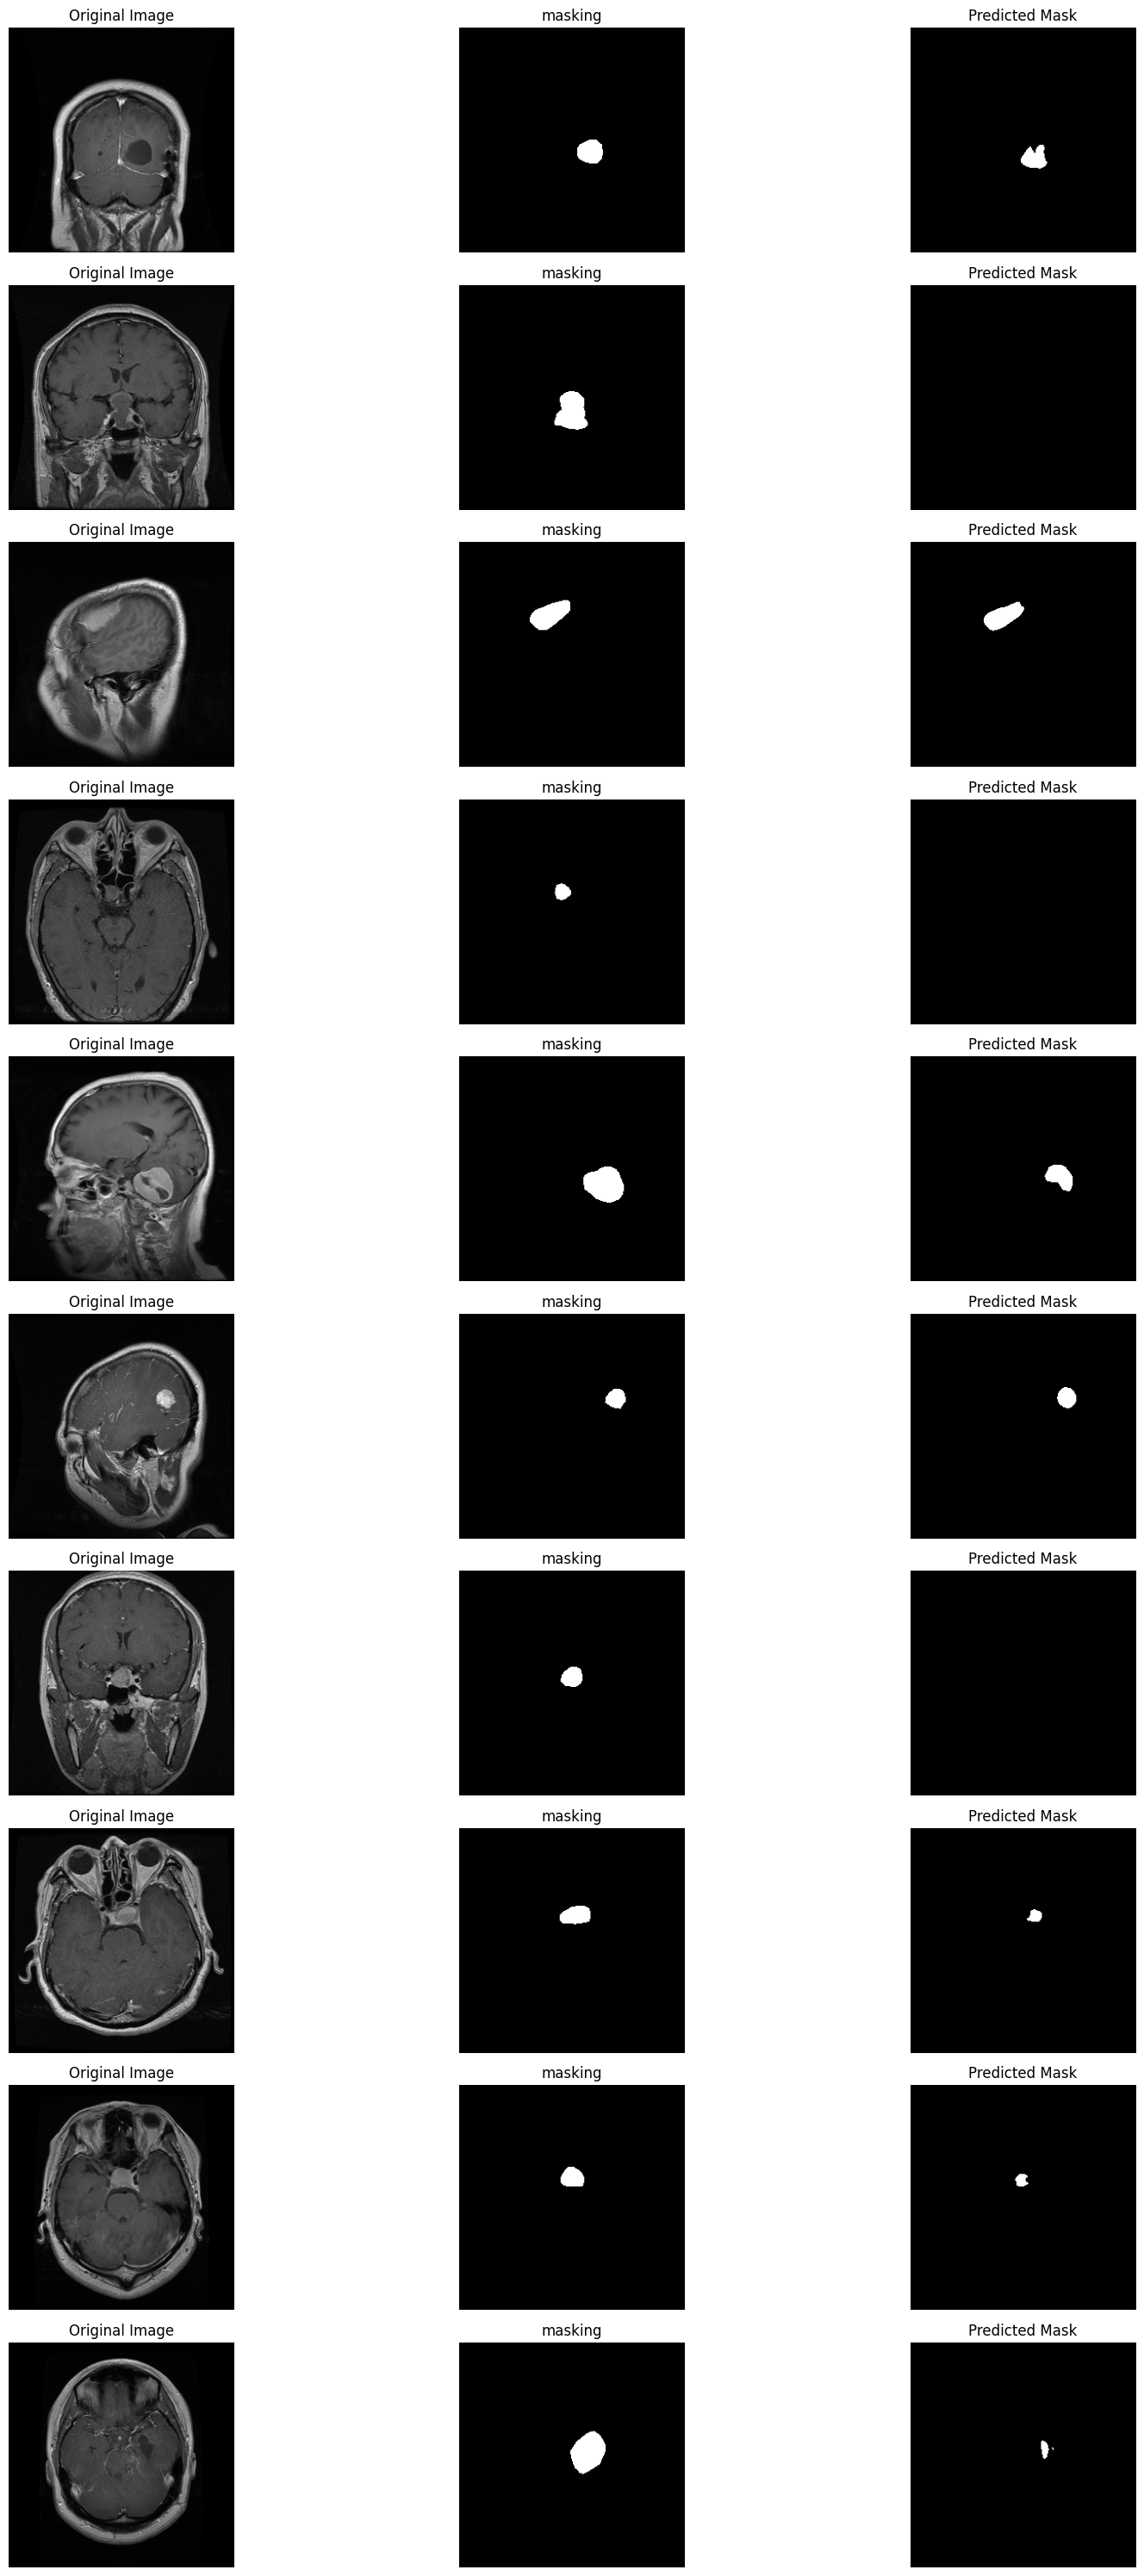

In [75]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import random

sample_images = random.sample(sorted(os.listdir(IMAGE_DIR)), 10)

plt.figure(figsize=(18, 30))

for i, fname in enumerate(sample_images):
   
    img = load_img(os.path.join(IMAGE_DIR, fname), color_mode='grayscale', target_size=(256, 256))
    x = np.expand_dims(img_to_array(img) / 255.0, axis=0)

    
    mask = load_img(os.path.join(MASK_DIR, fname), color_mode='grayscale', target_size=(256, 256))
    mask_arr = img_to_array(mask) / 255.0
    mask_arr = (mask_arr > 0.5).astype(np.uint8)

   
    pred_mask = model.predict(x)[0, ..., 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

     
    plt.subplot(10, 3, 3*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    
    plt.subplot(10, 3, 3*i + 2)
    plt.imshow(mask_arr.squeeze(), cmap='gray')
    plt.title('masking')
    plt.axis('off')

   
    plt.subplot(10, 3, 3*i + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()
